<a href="https://colab.research.google.com/github/Aravindh4404/FYPSeagullClassification01/blob/main/Inception_HQ_3010.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import numpy as np
import random

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Mount Google Drive to save and load the model (if using Google Colab)
from google.colab import drive
drive.mount('/content/drive')

# Define the folder to save model checkpoints
checkpoint_folder = '/content/drive/My Drive/FYP/ModelCheckpointsHQ_Inception/'
os.makedirs(checkpoint_folder, exist_ok=True)

# Data Augmentation for Training Set
transform_train = transforms.Compose([
    transforms.Resize((299, 299)),   # Inception v3 expects 299x299 input size
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
])

# Simple resizing for validation and test sets
transform_val_test = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
])

# Load datasets
data_path = '/content/drive/My Drive/FYP/Dataset/HQSBNGW/train'
test_data_path = '/content/drive/My Drive/FYP/Dataset/HQSBNGW/test'
train_dataset = datasets.ImageFolder(data_path, transform=transform_train)
test_dataset = datasets.ImageFolder(test_data_path, transform=transform_val_test)

# Split the dataset into 80% training and 20% validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Use Pre-trained Inception v3 model and modify it for binary classification
class InceptionV3Modified(nn.Module):
    def __init__(self):
        super(InceptionV3Modified, self).__init__()
        self.inception = models.inception_v3(pretrained=True)
        # Replace the final fully connected layer to output 2 classes
        num_ftrs = self.inception.fc.in_features
        self.inception.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_ftrs, 2)
        )

    def forward(self, x):
        # Use the auxiliary output during training to improve accuracy
        if self.training:
            aux, x = self.inception(x)
            return aux, x
        else:
            return self.inception(x)

# Initialize the Inception model
model = InceptionV3Modified()

# Define loss function and optimizer with L2 regularization (weight decay)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True)

# Early stopping class to monitor validation accuracy
class EarlyStopping:
    def __init__(self, patience=5, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_acc = None
        self.early_stop = False

    def __call__(self, val_acc, model, folder_path):
        if self.best_acc is None:
            self.best_acc = val_acc
            self.save_model(model, folder_path)
        elif val_acc <= self.best_acc:
            self.counter += 1
            if self.counter >= self.patience:
                if self.verbose:
                    print("Early stopping triggered!")
                self.early_stop = True
        else:
            self.best_acc = val_acc
            self.save_model(model, folder_path)
            self.counter = 0

    def save_model(self, model, folder_path):
        model_save_path = os.path.join(folder_path, "best_model_inception.pth")
        torch.save(model.state_dict(), model_save_path)
        print(f"Best model saved with accuracy: {self.best_acc:.4f}% at {model_save_path}")

# Initialize early stopping
early_stopping = EarlyStopping(patience=5, verbose=True)

# Training loop with early stopping and learning rate scheduler
def train(model, train_loader, val_loader, criterion, optimizer, scheduler, early_stopping, epochs=20):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            aux_outputs, outputs = model(inputs)  # Inception requires auxiliary outputs
            loss = criterion(outputs, labels) + 0.4 * criterion(aux_outputs, labels)  # 0.4 weight on aux loss
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Print the loss per epoch
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.6f}")

        # Validate the model and check accuracy
        val_acc = validate(model, val_loader, criterion)
        scheduler.step(val_acc)

        # Early stopping checks
        early_stopping(val_acc, model, checkpoint_folder)

        if early_stopping.early_stop:
            print("Early stopping - training stopped")
            break

# Validation loop returning accuracy
def validate(model, loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Validation Loss: {val_loss/len(loader):.6f}, Accuracy: {accuracy:.2f}%')
    return accuracy

# Test function to evaluate on the test set
def test(model, loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Test Loss: {test_loss/len(loader):.6f}, Test Accuracy: {accuracy:.2f}%')

# Run the full code sequence

# Step 1: Train the model with early stopping and learning rate scheduling
train(model, train_loader, val_loader, criterion, optimizer, scheduler, early_stopping, epochs=20)

# Step 2: Evaluate the model on the test set
test(model, test_loader, criterion)


Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 113MB/s] 
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the le

Epoch [1/20], Loss: 1.636738
Validation Loss: 0.823688, Accuracy: 77.85%
Best model saved with accuracy: 77.8481% at /content/drive/My Drive/FYP/ModelCheckpointsHQ_Inception/best_model_inception.pth
Epoch [2/20], Loss: 0.427253
Validation Loss: 0.340398, Accuracy: 92.41%
Best model saved with accuracy: 92.4051% at /content/drive/My Drive/FYP/ModelCheckpointsHQ_Inception/best_model_inception.pth
Epoch [3/20], Loss: 0.292992
Validation Loss: 0.244588, Accuracy: 91.77%
Epoch [4/20], Loss: 0.247510
Validation Loss: 0.306353, Accuracy: 86.71%
Epoch [5/20], Loss: 0.329471
Validation Loss: 0.398668, Accuracy: 85.44%
Epoch [6/20], Loss: 0.336904
Validation Loss: 0.235210, Accuracy: 95.57%
Best model saved with accuracy: 95.5696% at /content/drive/My Drive/FYP/ModelCheckpointsHQ_Inception/best_model_inception.pth
Epoch [7/20], Loss: 0.251080
Validation Loss: 0.120357, Accuracy: 95.57%
Epoch [8/20], Loss: 0.258398
Validation Loss: 0.478701, Accuracy: 84.81%
Epoch [9/20], Loss: 0.274476
Validatio

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-8-fda8c9ba1dc5>:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_location=torch.device('cpu')))


Model loaded from /content/drive/My Drive/FYP/ModelCheckpointsHQ_Inception/best_model_inception.pth


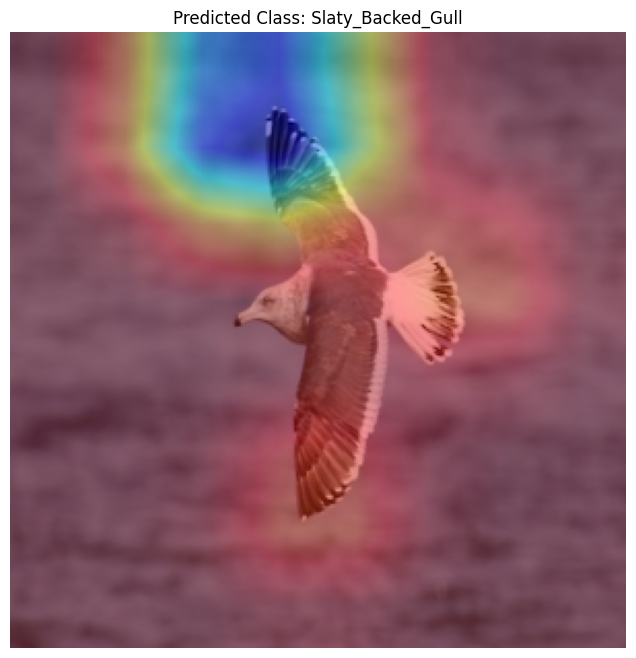

In [8]:
import torch
import torch.nn as nn
from torchvision import transforms, models
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Mount Google Drive to load the model and image
from google.colab import drive
drive.mount('/content/drive')

# Path to the saved model and test image
checkpoint_path = '/content/drive/My Drive/FYP/ModelCheckpointsHQ_Inception/best_model_inception.pth'
image_path = '/content/SlatybackedGull30.jpg'  # Update with actual test image path

# Define image transformation to match model input
transform = transforms.Compose([
    transforms.Resize((299, 299)),   # Inception v3 expects 299x299 input size
    transforms.ToTensor(),
])

# Define the modified Inception model with your custom fully connected layer
class InceptionV3Modified(nn.Module):
    def __init__(self):
        super(InceptionV3Modified, self).__init__()
        self.inception = models.inception_v3(pretrained=True)
        # Replace the final fully connected layer to output 2 classes
        num_ftrs = self.inception.fc.in_features
        self.inception.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_ftrs, 2)
        )

    def forward(self, x):
        if self.training:
            aux, x = self.inception(x)
            return aux, x
        else:
            return self.inception(x)

# Load the saved model weights
model = InceptionV3Modified()
model.load_state_dict(torch.load(checkpoint_path, map_location=torch.device('cpu')))
model.eval()

print(f"Model loaded from {checkpoint_path}")

# Class names as per dataset
class_names = ['Glaucous_Winged_Gull', 'Slaty_Backed_Gull']  # Adjust based on your class order

# Function to preprocess and load a single image
def preprocess_image(image_path):
    """Load an image and apply transformations."""
    image = Image.open(image_path).convert("RGB")
    image = transform(image)  # Apply transformations
    image = image.unsqueeze(0)  # Add batch dimension
    return image

# Function to generate Grad-CAM heatmap and show predicted class
def generate_gradcam_inception(model, image_tensor, target_layer, class_names):
    model.eval()
    features = []
    grads = []

    # Define hooks to capture feature maps and gradients
    def save_features_hook(module, input, output):
        features.append(output)

    def save_grads_hook(module, grad_in, grad_out):
        grads.append(grad_out[0])

    # Register hooks to the target layer
    hook1 = target_layer.register_forward_hook(save_features_hook)
    hook2 = target_layer.register_backward_hook(save_grads_hook)

    # Forward pass
    output = model(image_tensor)
    predicted_class_idx = output.argmax().item()
    predicted_class = class_names[predicted_class_idx]

    # Backward pass to get gradients
    model.zero_grad()
    class_loss = output[0, predicted_class_idx]
    class_loss.backward()

    # Process gradients and feature maps
    gradient = grads[0].cpu().data.numpy()[0]
    feature_map = features[0].cpu().data.numpy()[0]

    # Calculate Grad-CAM
    weights = np.mean(gradient, axis=(1, 2))  # Global average pooling of gradients
    cam = np.zeros(feature_map.shape[1:], dtype=np.float32)

    for i, w in enumerate(weights):
        cam += w * feature_map[i]

    cam = np.maximum(cam, 0)  # ReLU to remove negative values
    cam = cv2.resize(cam, (image_tensor.shape[3], image_tensor.shape[2]))  # Resize to match image dimensions
    cam -= np.min(cam)
    cam /= np.max(cam)  # Normalize between 0 and 1

    # Convert original image for heatmap overlay
    original_image = image_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
    original_image = (original_image - np.min(original_image)) / (np.max(original_image) - np.min(original_image))

    # Create heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam_image = 0.4 * heatmap + 0.6 * original_image

    # Show the image with the predicted class name
    plt.figure(figsize=(8, 8))
    plt.title(f"Predicted Class: {predicted_class}")
    plt.imshow(cam_image)
    plt.axis('off')
    plt.show()

    # Remove hooks
    hook1.remove()
    hook2.remove()

# Set the target layer for Grad-CAM
target_layer = model.inception.Mixed_7c  # Last convolutional layer in Inception v3

# Preprocess the image
image_tensor = preprocess_image(image_path)

# Generate Grad-CAM for the specific image and show the predicted class
generate_gradcam_inception(model, image_tensor, target_layer, class_names)
